In [24]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv(r"C:\Users\jkmfi\Documents\Quant_nifty_project\data\clean\nifty_features_5min.csv")

In [26]:
df = df.reset_index(drop=True)
print(df.shape)

(250, 21)


### EMA STRATEGY

In [27]:
# Safety check
df = df.dropna(subset=['EMA_5', 'EMA_15', 'Close_spot'])

In [28]:
# EMA Signal
df['EMA_Signal'] = 0

df.loc[
    (df['EMA_5'] > df['EMA_15']) &
    (df['EMA_5'].shift(1) <= df['EMA_15'].shift(1)),
    'EMA_Signal'
] = 1

df.loc[
    (df['EMA_5'] < df['EMA_15']) &
    (df['EMA_5'].shift(1) >= df['EMA_15'].shift(1)),
    'EMA_Signal'
] = -1


In [29]:
# Position
df['Position'] = df['EMA_Signal'].replace(0, np.nan).ffill().fillna(0)

### RETURNS & STRATEGY RETURNS

In [30]:
df['Return'] = np.log(df['Close_spot'] / df['Close_spot'].shift(1))
df['Strategy_Return'] = df['Position'].shift(1) * df['Return']

df[['Return', 'Strategy_Return']] = df[['Return', 'Strategy_Return']].fillna(0)

### TARGET DEFINITION

In [31]:
df['Target'] = (df['Strategy_Return'] > 0).astype(int)

### FEATURE ENGINEERING

In [32]:
# EMA features
df['EMA_diff'] = df['EMA_5'] - df['EMA_15']
df['EMA_trend'] = (df['EMA_diff'] > 0).astype(int)
df['EMA_strength'] = df['EMA_diff'].abs()

# Return features
df['Return_1'] = df['Close_spot'].pct_change()
df['Return_lag_1'] = df['Return_1'].shift(1)

# Position memory
df['Position_lag_1'] = df['Position'].shift(1)

# Time features
df['TradeDate'] = pd.to_datetime(df['TradeDate'], errors='coerce')
df['Hour'] = df['TradeDate'].dt.hour
df['DayOfWeek'] = df['TradeDate'].dt.dayofweek

In [33]:
# Volatility regime
df['Volatility'] = df['Return'].rolling(20).std()

# Regime labeling
df['Regime'] = 0
df.loc[df['Volatility'] > df['Volatility'].median(), 'Regime'] = 1

### FINAL ML DATASET

In [35]:
feature_cols = [
    'EMA_diff',
    'EMA_trend',
    'EMA_strength',
    'Return_lag_1',
    'Position_lag_1',
    'Hour',
    'DayOfWeek',
    'Regime'
]

df_ml = df[feature_cols + ['Target', 'Strategy_Return']].dropna()

X = df_ml[feature_cols]
y = df_ml['Target']

print(X.shape, y.value_counts())

(248, 8) 0    132
1    116
Name: Target, dtype: int64


### MODEL A — XGBOOST (TIME-SERIES CV)

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

In [37]:
tscv = TimeSeriesSplit(n_splits=5)

best_auc = -1
best_xgb = None

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)

    print("Fold AUC:", round(auc, 3))

    if auc > best_auc:
        best_auc = auc
        best_xgb = model

print("Best Regime-Aware XGB AUC:", round(best_auc, 3))

Fold AUC: 0.49
Fold AUC: 0.548
Fold AUC: 0.595
Fold AUC: 0.553
Fold AUC: 0.548
Best Regime-Aware XGB AUC: 0.595


### MODEL B — LSTM (SEQUENCE MODEL)

In [38]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Build sequences

In [40]:
LOOKBACK = 10
X_seq, y_seq = [], []

for i in range(LOOKBACK, len(X_scaled)):
    X_seq.append(X_scaled[i-LOOKBACK:i])
    y_seq.append(y.iloc[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(X_seq.shape, y_seq.shape)

(238, 10, 8) (238,)


#### LSTM model

In [41]:
model_lstm = Sequential([
    LSTM(32, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_lstm.fit(
    X_seq,
    y_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
7/7 [==============================] - 2s 53ms/step - loss: 0.7304 - accuracy: 0.4299 - val_loss: 0.7223 - val_accuracy: 0.4167
Epoch 2/30
7/7 [==============================] - 0s 7ms/step - loss: 0.7149 - accuracy: 0.4766 - val_loss: 0.7126 - val_accuracy: 0.4167
Epoch 3/30
7/7 [==============================] - 0s 6ms/step - loss: 0.7024 - accuracy: 0.4533 - val_loss: 0.7068 - val_accuracy: 0.4583
Epoch 4/30
7/7 [==============================] - 0s 7ms/step - loss: 0.6874 - accuracy: 0.5654 - val_loss: 0.7025 - val_accuracy: 0.5417
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6752 - accuracy: 0.6215 - val_loss: 0.6995 - val_accuracy: 0.5833
Epoch 6/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6723 - accuracy: 0.5888 - val_loss: 0.6989 - val_accuracy: 0.5000
Epoch 7/30
7/7 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.6075 - val_loss: 0.6993 - val_accuracy: 0.4583
Epoch 8/30
7/7 [=================

### ML-ENHANCED BACKTEST

In [49]:
# Trim df to match LSTM sequence length
LOOKBACK = X_seq.shape[1]
N = len(X_seq)

df_bt = df.iloc[-N:].copy()

# XGBoost input (STRICT feature match)
X_bt = df_bt[feature_cols]

In [50]:
THRESHOLD = 0.6

# XGBoost
df_bt['XGB_prob'] = best_xgb.predict_proba(X_bt)[:, 1]

# LSTM
df_bt['LSTM_prob'] = model_lstm.predict(X_seq, verbose=0).flatten()

# Binary ML signals
df_bt['ML_XGB'] = (df_bt['XGB_prob'] > THRESHOLD).astype(int)
df_bt['ML_LSTM'] = (df_bt['LSTM_prob'] > THRESHOLD).astype(int)

In [51]:
# Final trade condition:
# 1) High ML confidence
# 2) High-volatility regime only
df_bt['Final_Trade'] = (
    (df_bt['XGB_prob'] > THRESHOLD) &
    (df_bt['Regime'] == 1)
).astype(int)

# Regime + ML filtered returns
df_bt['Strategy_Return_RegimeML'] = (
    df_bt['Strategy_Return'] * df_bt['Final_Trade']
)

### Predictions

In [52]:
df_bt['XGB_prob'] = best_xgb.predict_proba(X_bt)[:, 1]
df_bt['LSTM_prob'] = model_lstm.predict(X_seq, verbose=0).flatten()

df_bt['ML_XGB'] = (df_bt['XGB_prob'] > THRESHOLD).astype(int)
df_bt['ML_LSTM'] = (df_bt['LSTM_prob'] > THRESHOLD).astype(int)

### Filtered returns

In [53]:
df_bt['Return_XGB'] = df_bt['Strategy_Return'] * df_bt['ML_XGB']
df_bt['Return_LSTM'] = df_bt['Strategy_Return'] * df_bt['ML_LSTM']

### PERFORMANCE COMPARISON

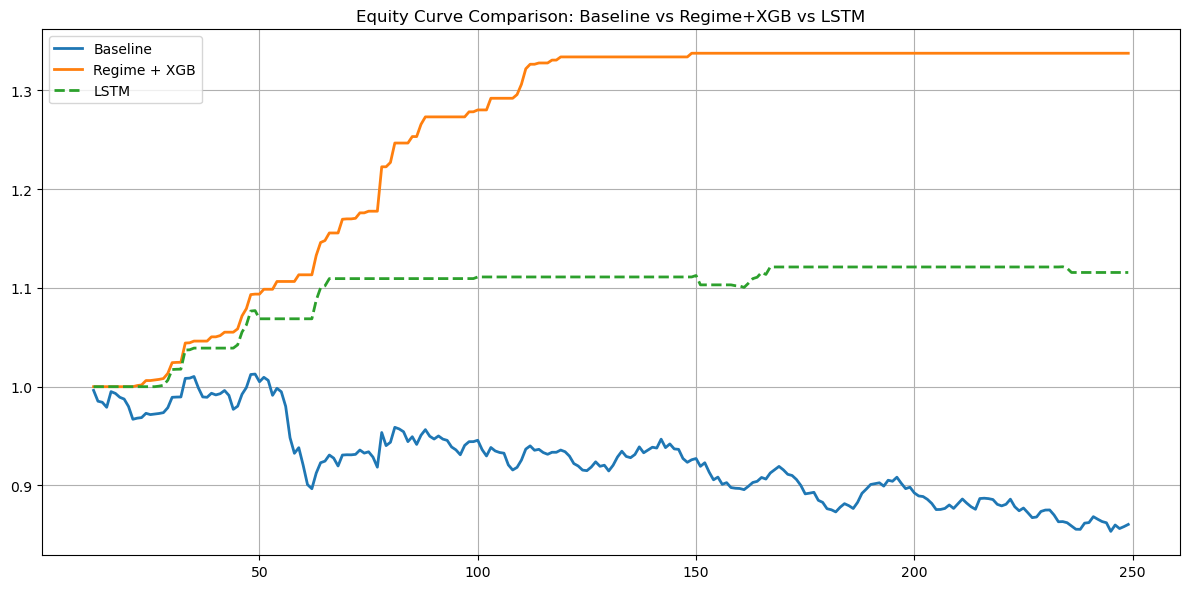

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def equity_curve(r):
    return np.exp(r.cumsum())

plt.figure(figsize=(12,6))

# Baseline EMA strategy
plt.plot(
    equity_curve(df_bt['Strategy_Return']),
    label='Baseline',
    linewidth=2
)

# Regime + XGB filtered strategy
plt.plot(
    equity_curve(df_bt['Strategy_Return_RegimeML']),
    label='Regime + XGB',
    linewidth=2
)

# LSTM filtered strategy
plt.plot(
    equity_curve(df_bt['Return_LSTM']),
    label='LSTM',
    linewidth=2,
    linestyle='--'
)

plt.legend()
plt.title("Equity Curve Comparison: Baseline vs Regime+XGB vs LSTM")
plt.grid(True)
plt.tight_layout()
plt.show()


Note-

"I use ML as a trade filter, not a signal generator.
The base strategy creates trades, and ML predicts whether to accept or reject them based on historical profitability using time-series validation."

In [55]:
import os

MODEL_DIR = "Quant_nifty_project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [56]:
best_xgb.save_model(f"{MODEL_DIR}/xgb_model.json")

In [57]:
model_lstm.save(f"{MODEL_DIR}/lstm_model.keras")

In [60]:
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")

['Quant_nifty_project/models/scaler.pkl']

In [61]:
joblib.dump(feature_cols, f"{MODEL_DIR}/feature_cols.pkl")

['Quant_nifty_project/models/feature_cols.pkl']